# Notebook to make example surface and cross-sectional plots with the TXLA model. Salinity is used here as an example

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Open history and output files from hafen

In [2]:
paths = ['https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_his_2021_v2_agg', # Parent, his file
         'https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_avg_2021_v2_agg'] # Parent, avg file

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

## Make a series of increasingly complex plots of surface salinity at a single time.
    - xarray's built in plotting function
    - using matplotlib and cartopy directly 
    - adding extra features onto the indirect version like isobaths, coastlines, etc

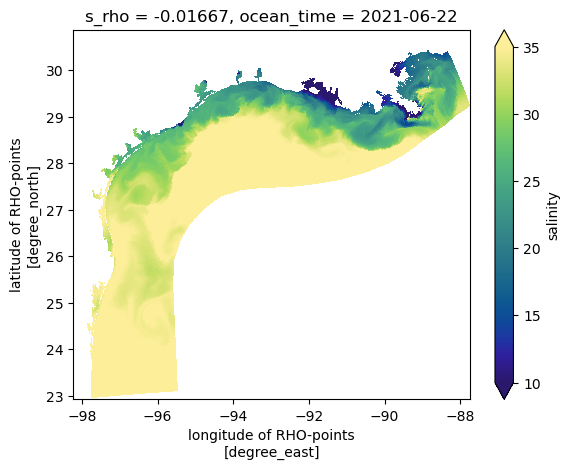

In [8]:
sss = ds[0].salt.isel(s_rho = -1).sel(ocean_time = '06-22-21 00:00')
sss.plot(x = 'lon_rho', y = 'lat_rho', cmap = cmo.haline, vmin = 10, vmax = 35)

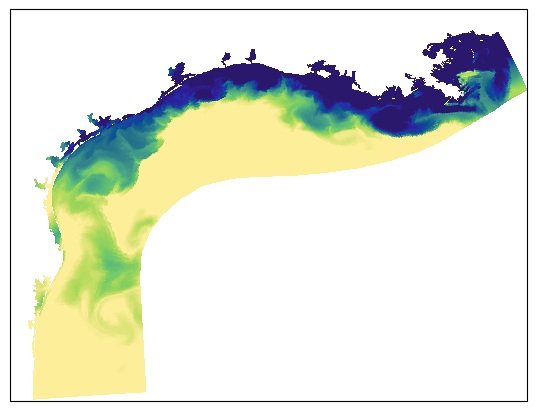

In [11]:
plt.rcParams.update({'font.size': 10})
ncols = 1 ; nrows = 1
crs = ccrs.PlateCarree(central_longitude=-92.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True)

mappable3 = ax.pcolormesh(ds[0].lon_rho,
                          ds[0].lat_rho,
                          sss, 
                          cmap = cmo.haline, vmin = 25, vmax = 35,
                          transform = ccrs.PlateCarree())

### Add colorbar 

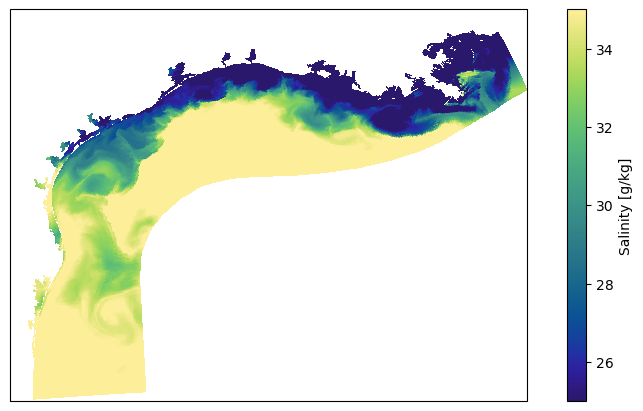

In [16]:
fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True)

m = ax.pcolormesh(ds[0].lon_rho,
                  ds[0].lat_rho,
                  sss, 
                  cmap = cmo.haline, vmin = 25, vmax = 35,
                  transform = ccrs.PlateCarree())

plt.colorbar(m).set_label(r'Salinity [g/kg]') 
fig.canvas.draw()

### Add extra land features 

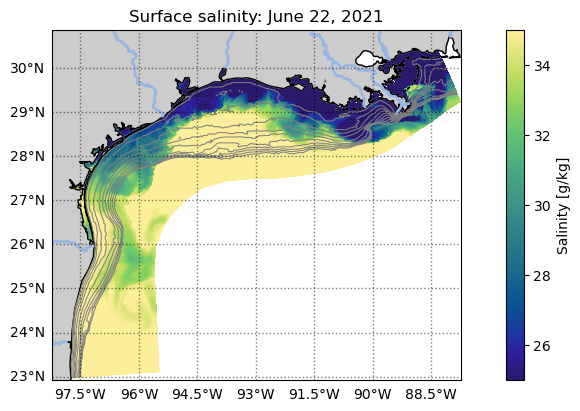

In [26]:
lat_rad = 1.0/np.cos(np.radians(ds[0].lat_rho.mean().values))

fig,ax = plt.subplots(nrows,ncols,figsize=(18/1.75,8/2),
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True)

m = ax.pcolormesh(ds[0].lon_rho,
                  ds[0].lat_rho,
                  sss, 
                  cmap = cmo.haline, vmin = 25, vmax = 35,
                  transform = ccrs.PlateCarree())

plt.colorbar(m).set_label(r'Salinity [g/kg]')

hlevs = [10, 20, 30, 40, 50, 60, 70, 80,90,100] # isobath contour depths
ax.contour(ds[0].lon_rho,
           ds[0].lat_rho,
           ds[0].h, hlevs, colors='grey', 
           transform=ccrs.PlateCarree(), linewidths=0.75)
# ax.set_extent([-95, -88, 27.75, 30.5], crs=ccrs.PlateCarree()) # query axes limits in lon/lat
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
ax.coastlines(resolution='10m', linewidth = 1)  # add coastlines 
ax.set_aspect(lat_rad) # set aspect ratio
ax.add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers
ax.set_title('Surface salinity: June 22, 2021')

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True) # grid lines 
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
    
fig.canvas.draw()
# plt.savefig('overview_sat_model.jpg', dpi = 300, bbox_inches='tight', ) # save figure with 300 DPI and tight corners to eliminate whitespace

## Now add in a cross section example.
This can get tricky regarding the coordinates for plotting 

In [32]:
# Create the indices for the cross-section xislice_cs = 396
xislice = slice(271,404)
etaslice = slice(31,149)
xislice_cs = 396
etaslice_cs = etaslice

salt_cs = ds[0].salt.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = '06-22-21 00:00')
salt_cs

<xarray.DataArray 'salt' (s_rho: 30, eta_rho: 118)>
dask.array<getitem, shape=(30, 118), dtype=float32, chunksize=(30, 118), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho) float64 dask.array<chunksize=(118,), meta=np.ndarray>
    lat_rho     (eta_rho) float64 dask.array<chunksize=(118,), meta=np.ndarray>
    ocean_time  datetime64[ns] 2021-06-22
    xi_rho      int64 396
  * eta_rho     (eta_rho) int64 31 32 33 34 35 36 37 ... 143 144 145 146 147 148
    z_rho       (s_rho, eta_rho) float64 dask.array<chunksize=(30, 118), meta=np.ndarray>
Attributes:
    long_name:    salinity
    time:         ocean_time
    grid:         grid
    location:     face
    field:        salinity, scalar, series
    _ChunkSizes:  [  1  15  96 336]

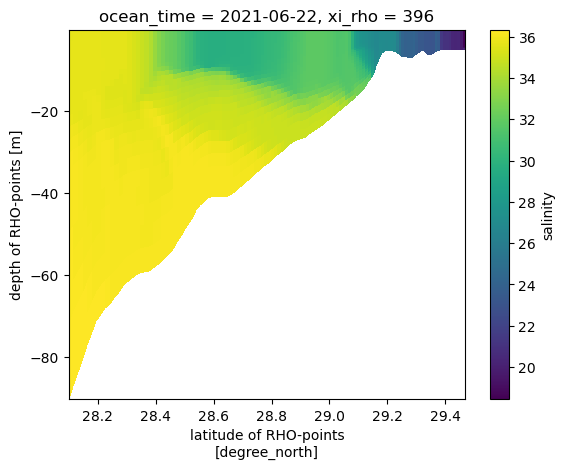

In [33]:
salt_cs.plot(x='lat_rho',y='z_rho')

### In the example above, salinity is already ready for plotting since it is on the rho points. 
If we were slicing a variable not on the rho points or had to do some interpolation for one variable, we will need to fix the coordinates as well, which can be done with 'assign_coordinates'. Suppose 'lat_rho' and 'z_rho' were missing from our coordinates and we needed them for plotting. We could add them to here by uncommenting and running the following line

In [35]:
# salt_srho = salt.assign_coords({'lat_rho':(ds_[0].lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)), 
#                                 'z_rho':(ds_[0].z_rho.sel(ocean_time = '06-22-21 00:00').isel(eta_rho = etaslice_cs, xi_rho = xislice_cs))})

Text(0.5, 1.0, 'Salinity cross section')

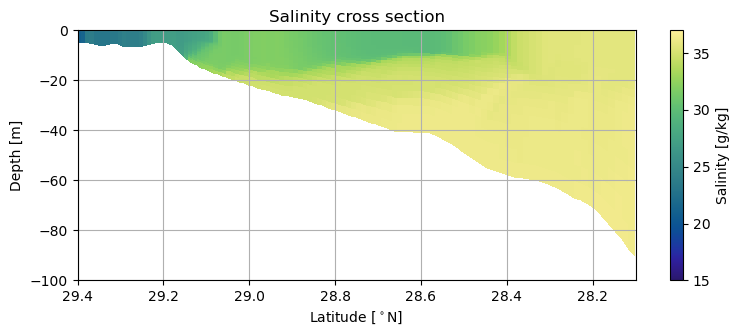

In [74]:
salt_cs.plot(x='lat_rho',y='z_rho', figsize = (9,3.25), 
             cmap = cmo.haline, vmin = 15, vmax = 37,
             cbar_kwargs = {'label':'Salinity [g/kg]', 'ticks':[5,10,15,20,25,30,35]})
plt.xlim(29.4,28.1) # reverse the limits so seaward is right 
plt.grid()
plt.ylim(-100,0)

#Labels & title
plt.xlabel('Latitude [$^\circ$N]')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')

### Last modification: add some isopycnals since that is a common feature to add with cross-sections 

In [60]:
rho = xroms.potential_density(ds[0].temp.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = '2021-06-22 00:00'), 
                              ds[0].salt.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = '2021-06-22 00:00'), 
                              z=0).load()

In [67]:
print('Density extrema [kg/m^3]', rho.min().values, rho.max().values)

Density extrema [kg/m^3] 1009.5445 1026.3771


Text(0.5, 1.0, 'Salinity cross section')

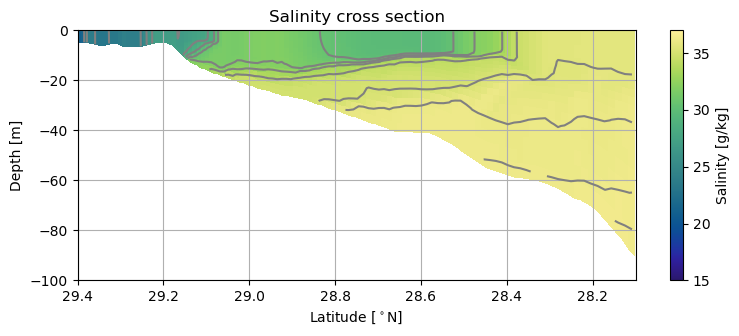

In [75]:
salt_cs.plot(x='lat_rho',y='z_rho', figsize = (9,3.25), 
             cmap = cmo.haline, vmin = 15, vmax = 37,
             cbar_kwargs = {'label':'Salinity [g/kg]', 'ticks':[5,10,15,20,25,30,35]})
rho.plot.contour(x='lat_rho',y='z_rho', levels = np.arange(1009,1027,1), colors = 'gray', inline = False) #contours

plt.xlim(29.4,28.1) # reverse the limits so seaward is right 
plt.ylim(-100,0)
plt.grid()

#Labels & title
plt.xlabel('Latitude [$^\circ$N]')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')